# Generative Adversarial Learning for Intelligent 5G Interference Mitigation

In this notebook, we implement a generative adversarial network (GAN) for use in 5G wireless interference mitigation.

In [21]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

sns.set() # Use seaborn themes.

In [2]:
# Here define some root paths for saving content.
roots = dict(
    dataset = Path('./dataset/'),
    images = Path('./images/'),
)
for k,r in roots.items(): # Create directories if they do not already exist.
    if not r.exists():
        r.mkdir(exist_ok=True)

## Types of Adversarial Attacks

1. Attack on 5G spectrum sharing ([section IV-A](https://arxiv.org/pdf/2101.02656.pdf))
    * Discriminator learns whether channel is idle or busy (based on [RSSIs](https://en.wikipedia.org/wiki/Received_signal_strength_indication))
    * Generator learns to transmit when channel is considered idle to make the channel be considered busy
1. Attack on signal authentication in network slicing ([section IV-B](https://arxiv.org/pdf/2101.02656.pdf))
    * The network provides services to authenticated user equipment (UE, i.e., cellphones)
    * Discriminator is trained to identify UEs for auth (trained on signal I/Q data, both power and phase)
    * Generator produces signals with I/Q that match those of authenticated UEs by monitoring the wireless environment

## Data Input and Preprocessing

In this work we use raw signal data, which takes the form of complex numbers (called "IQ"). However, a currently limitation of TensorFlow models is that they cannot accept complex data as input. The reason for this is because values must be *ordered* for their gradient to exist, which is true for real numbers, and false for complex numbers. Therefore, we convert the IQ data into `magnitude` and `phase` features, which are real-valued elements.

In [48]:
def load_data(fname: str) -> tuple[np.ndarray, dict]:
    # Load numpy NPZ file.
    data = np.load(f"{fname}.npz")

    # Load parameter from JSON file.
    with open(f"{fname}.json", 'r') as f:
        params = json.load(f)
    return data, params

In [50]:
def plot(
    n: np.ndarray,
    s: np.ndarray,
    x: np.ndarray,
    fs: float,
    baud: int,
    ):

    plt.figure()

    fig, axd = plt.subplot_mosaic("A;B;C", figsize=(7,12))
    pkey = 'A'
    axd[pkey].plot(n, s, marker='o', markevery=int(fs/baud))
    axd[pkey].set_title('Data')

    pkey = 'B'
    axd[pkey].plot(n, np.real(x), label='real')
    axd[pkey].plot(n, np.imag(x), label='imag')
    axd[pkey].set_title('Signal')
    axd[pkey].legend()

    pkey = 'C'
    axd[pkey].plot(np.real(x.round(10)), np.imag(x.round(10)), '.')
    axd[pkey].set_title('Constellation')
    axd[pkey].grid(True)

    return fig

<Figure size 432x288 with 0 Axes>

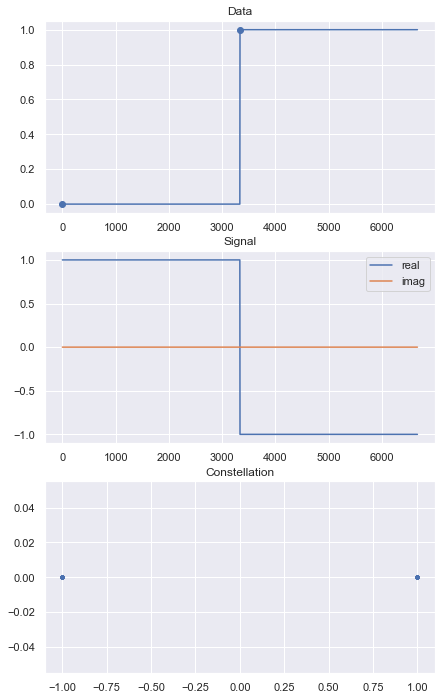

In [51]:
data, params = load_data(roots['dataset']/"bpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 432x288 with 0 Axes>

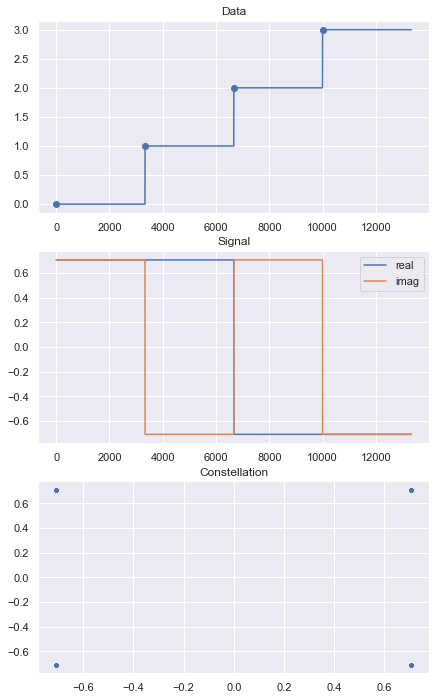

In [52]:
data, params = load_data(roots['dataset']/"qpsk")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 432x288 with 0 Axes>

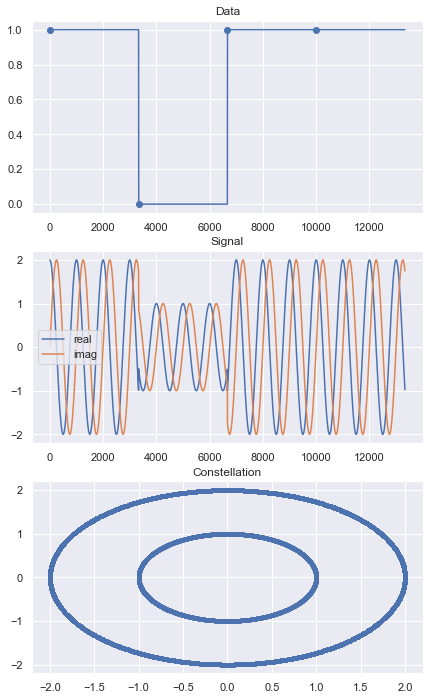

In [53]:
data, params = load_data(roots['dataset']/"2-ask")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 432x288 with 0 Axes>

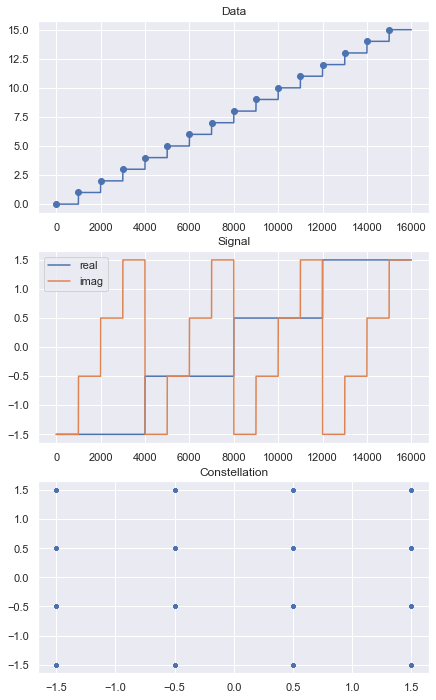

In [54]:
data, params = load_data(roots['dataset']/"16-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)

<Figure size 432x288 with 0 Axes>

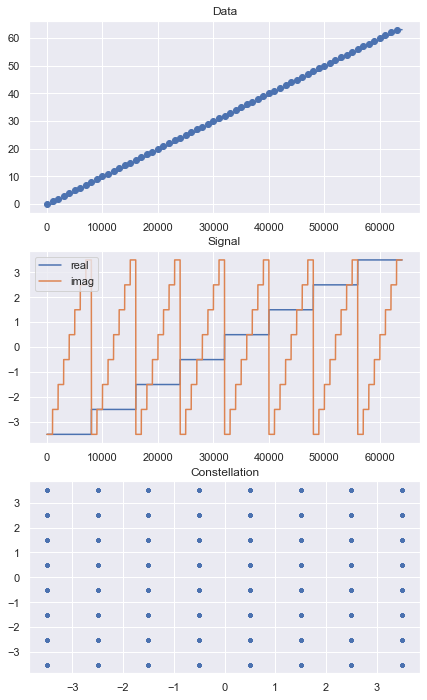

In [55]:
data, params = load_data(roots['dataset']/"64-qam")
fig = plot(
    n=data['n'],
    s=data['s'],
    x=data['x'],
    fs=params['fs'],
    baud=params['baud'],
)